# Italian fantasy Football Machine Learning Part 1

In the following notebook I'll present some insights on basic fantasy football statistics. The datasets are available on https://www.fantacalcio.it/statistiche-serie-a/2019-20/fantacalcio/riepilogo. I took data from 2015-16 to 2018-19 seasons. The final scope is to build a simple model to predict the next year average fanta vote for each player. Let's start importing all necessary python modules: 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split

### Data analysis

We import data into pandas DataFrames (We exclude players with less then 25 matches played). Let's take a look to the 2018-2019 season data: 

In [2]:
fanta_datasets = {}

for i in [15,16,17,18]:
    try:
        fanta_datasets['fanta_20{}_20{}'.format(i,i+1)] = pd.read_excel(
                                                        'Statistiche_Fantacalcio_20{}-{}.xlsx'.format(i,i+1), sheet_name='Tutti')
    except FileNotFoundError:
        pass

for k, v in fanta_datasets.items():
    fanta_datasets[k] = v[v.Pg >= 20]

fanta_datasets['fanta_2018_2019'].head(5)

,Id,R,Nome,Squadra,Pg,Mv,Mf,Gf,Gs,Rp,Rc,R+,R-,Ass,Asf,Amm,Esp,Au
0,4,P,SPORTIELLO,Frosinone,35,6.11,4.21,0,64,0,0,0,0,0,0,5,0,0
2,15,D,MASIELLO A,Atalanta,23,5.83,5.67,0,0,0,0,0,0,1,0,5,0,1
3,20,C,CIGARINI,Cagliari,23,5.87,5.72,0,0,0,0,0,0,1,0,9,0,0
4,21,C,D'ALESSANDRO,Udinese,20,5.95,5.92,0,0,0,0,0,0,1,0,3,0,0
5,22,C,DE ROON,Atalanta,34,6.01,6.10,1,0,0,1,1,0,1,0,8,0,0


Each row corresponds to specific player with a unique Id. We can see several details for each player as the Role (the acronims stand for the role in Italian, for example "P = Portiere" in English Goalkeeper), the Name, Squad, Average vote, Average Fanta vote, goal scored and so on. 

We have two categorical fields, the players' roles and the teams. We exclude the teams because they are not fixed due to downgrading on each season. Plotting the mean fanta vote versus the role, we can see how the vote is related to the players' role. Goalkeeprs are more penalised than other players' role, due to the large sum of goals scored by the opponents. 

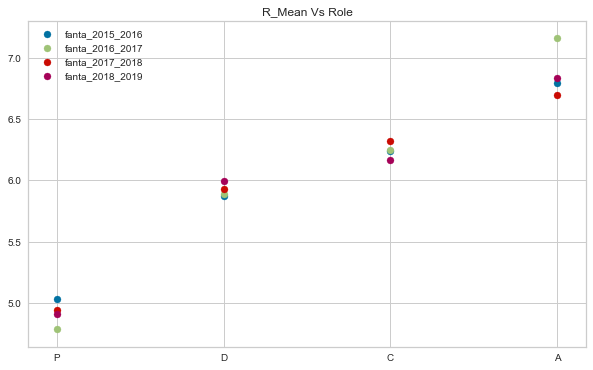

In [3]:
fig=plt.figure(figsize=(10,6))

for k, v in fanta_datasets.items():
    v['R_Mean'] = v.groupby('R')['Mf'].transform('mean')
    plt.scatter(v[['R','R_Mean']].drop_duplicates()['R'],v[['R','R_Mean']].drop_duplicates()['R_Mean'], label = k)
plt.legend(loc='best')
plt.title('R_Mean Vs Role')
plt.show()
plt.close()

Let's see the teams' table for the 2018/2019 season order by the average fanta vote per team (The result is of the same type also for the other seasons). We can compare it with the final league table of the same season (https://en.wikipedia.org/wiki/2018%E2%80%9319_Serie_A). We can immediately see teams relegated to the below league not in the last positions in our table Or how Juventus is not the first for Mf. This means that the fanta vote is somewhat not strongly related to the final positions in the table league. In the preprocessing phase we'll take care of the teams statistics in order to improve the vote predictions for each player.

In [4]:
fanta_datasets['fanta_2018_2019'].groupby('Squadra', as_index=False)['Mf'].mean().sort_values(by='Mf',ascending=False)

,Squadra,Mf
12,Napoli,6.718000
9,Juventus,6.492143
0,Atalanta,6.470000
11,Milan,6.352500
18,Torino,6.348571
8,Inter,6.305714
14,Roma,6.288571
16,Sampdoria,6.279231
10,Lazio,6.271429
4,Empoli,6.200000


We now merge the seasons data as duplets

In [5]:
all_fanta = {}

for i in [15,16,17,18]:
    try:
        all_fanta['fanta_{}_{}'.format(i+1,i+2)] = pd.merge(
                                                    fanta_datasets['fanta_20{}_20{}'.format(i,i+1)], 
                                                    fanta_datasets['fanta_20{}_20{}'.format(i+1,i+2)], 
                                                    on='Id',suffixes=('_20{}'.format(i+1),'_20{}'.format(i+2)))
    except KeyError:
        break
        
all_fanta['fanta_18_19'].head()

,Id,R_2018,Nome_2018,Squadra_2018,Pg_2018,Mv_2018,Mf_2018,Gf_2018,Gs_2018,Rp_2018,...,Rp_2019,Rc_2019,R+_2019,R-_2019,Ass_2019,Asf_2019,Amm_2019,Esp_2019,Au_2019,R_Mean_2019
0,4,P,SPORTIELLO,Fiorentina,37,6.08,5.11,0,38,1,...,0,0,0,0,0,0,5,0,0,4.908333
1,15,D,MASIELLO A,Atalanta,31,6.26,6.56,4,0,0,...,0,0,0,0,1,0,5,0,1,5.992976
2,20,C,CIGARINI,Cagliari,26,5.85,5.81,2,0,0,...,0,0,0,0,1,0,9,0,0,6.165625
3,22,C,DE ROON,Atalanta,33,5.92,6.02,2,0,0,...,0,1,1,0,1,0,8,0,0,6.165625
4,26,A,GOMEZ A,Atalanta,33,6.32,7.02,4,0,0,...,0,0,0,0,9,1,5,0,0,6.835536


As final step of our analysis let's plot the next year average fantavote versus the previous year average fantavote for each seasons duplet

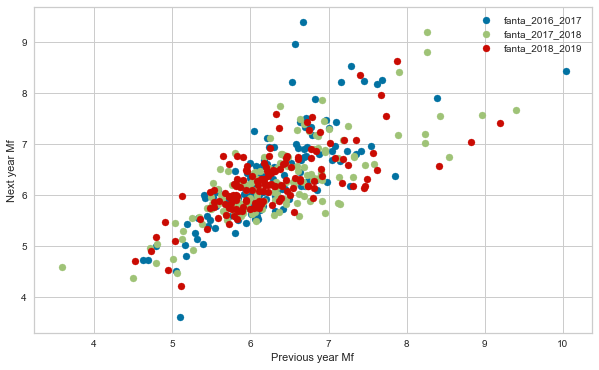

In [6]:
fig = plt.figure(figsize=(10,6))

for i in [15,16,17,18]:
    try:
        plt.scatter(all_fanta['fanta_{}_{}'.format(i,i+1)]['Mf_20{}'.format(i)],
                all_fanta['fanta_{}_{}'.format(i,i+1)]['Mf_20{}'.format(i+1)], label='fanta_20{}_20{}'.format(i,i+1))
    except KeyError:
        continue
plt.legend(loc='best')
plt.xlabel('Previous year Mf')
plt.ylabel('Next year Mf')
plt.show()
plt.close()

The points distribution is roughly the same for all seasons duplets considered. Moreover, at the first order there seems to be a linear trend. In the following we'll examine two models in order to exploits all the information hided in the datasets and predict the fantavote for the next year.

### Preprocessing and models

First we label the categorical data and assign a coefficient as the rough product between matches played and fantavote

In [7]:
lbl_R = {'P':0, 'D':1, 'C':2, 'A':3}

for k, v in all_fanta.items():
    for col in v.filter(like='R_20').columns:
        v[col+'_T'] = v[col].map(lbl_R)

for k, v in all_fanta.items():
    for col1, col2 in zip(v.filter(like='Pg').columns, v.filter(like='Mf').columns):
        v[col2+'_Weight'] = v[col1]*v[col2]

Now, we'll add the mean per teams for almost all the fields of the datasets

In [8]:
def means_per_team(all_fanta):
    try:
        for i in [16,17,18]:
            tab = all_fanta['fanta_{}_{}'.format(i,i+1)]
            cols_1 = [l for l in tab.filter(like='20{}'.format(i)).columns if l not in ['R_20{}'.format(i),'Nome_20{}'.format(i), 
                                                                            'Squadra_20{}'.format(i), 'Pg_20{}'.format(i), 
                                                                            'Mv_20{}'.format(i), 'R_Mean_20{}'.format(i),
                                                                            'R_20{}_T'.format(i), 'Mf_20{}_Weight'.format(i)]]
            cols_2 = [l for l in tab.filter(like='20{}'.format(i+1)).columns if l not in ['R_20{}'.format(i+1),'Nome_20{}'.format(i+1), 
                                                                            'Squadra_20{}'.format(i+1), 'Pg_20{}'.format(i+1), 
                                                                            'Mv_20{}'.format(i+1), 'R_Mean_20{}'.format(i+1),
                                                                            'R_20{}_T'.format(i+1), 'Mf_20{}_Weight'.format(i+1)
                                                                                ]]
            for col1, col2 in zip(cols_1, cols_2):
                tab[col1 + '_mean'] = tab.groupby('Squadra_20{}'.format(i))[col1].transform('mean')
                tab[col2 + '_mean'] = tab.groupby('Squadra_20{}'.format(i+1))[col2].transform('mean')

            all_fanta['fanta_{}_{}'.format(i,i+1)] = tab
    except KeyError:
        pass
    
    return all_fanta

all_fanta = means_per_team(all_fanta)

In [9]:
previous_year=17
next_year=18
test_year=19

fcol17 = [l for l in all_fanta['fanta_{}_{}'.format(previous_year,next_year)].
                                                    filter(like='20{}'.format(previous_year)).columns if l not in [
                                                                        'Id','R_20{}'.format(previous_year),
                                                                        'Nome_20{}'.format(previous_year),
                                                                        'Squadra_20{}'.format(previous_year),
                                                                        'Mv_20{}'.format(previous_year)]]

fcol18 = [l for l in all_fanta['fanta_{}_{}'.format(next_year,test_year)].
                                                    filter(like='20{}'.format(next_year)).columns if l not in [
                                                                        'Id','R_20{}'.format(next_year),
                                                                        'Nome_20{}'.format(next_year),
                                                                        'Squadra_20{}'.format(next_year),
                                                                        'Mv_20{}'.format(next_year)]]


X_train = all_fanta['fanta_{}_{}'.format(previous_year,next_year)][fcol17].dropna().values

Y_train = all_fanta['fanta_{}_{}'.format(previous_year,next_year)]['Mf_2018'].dropna().values

X_test = all_fanta['fanta_{}_{}'.format(next_year,test_year)][fcol18].dropna().values

Y_test = all_fanta['fanta_{}_{}'.format(next_year,test_year)]['Mf_2019'].dropna().values

In [10]:
#lc = LinearRegression(normalize=True)
lc = Ridge(alpha=2,normalize=True)
lc.fit(X_train, Y_train)
print('Lo score sul training è ', lc.score(X_train, Y_train))
print('Lo score sul test è ', lc.score(X_test, Y_test))

Lo score sul training è  0.6081202649334821
Lo score sul test è  0.5364991506008938


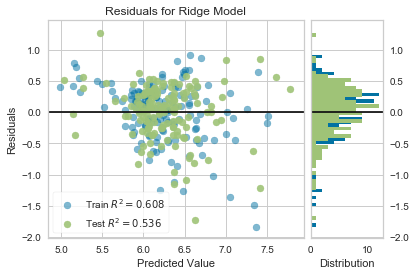

In [11]:
#### PLOT RESIDUALS ON LC ####

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(lc)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [12]:
####### Let's try with random forest #######

rf = RandomForestRegressor(n_estimators=150, max_depth=50, min_samples_leaf=5)
rf.fit(X_train, Y_train)
print('Lo score sul training è ', rf.score(X_train, Y_train))
print('Lo score sul test è ', rf.score(X_test, Y_test))

Lo score sul training è  0.7943963133320255
Lo score sul test è  0.5288022824314031


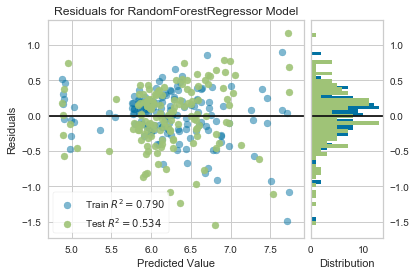

In [13]:
#### PLOT RESIDUALS ON RF ####

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [14]:
ereg = VotingRegressor([('lc', lc), ('rf', rf)])
ereg.fit(X_train, Y_train)
print('Lo score sul training è ', ereg.score(X_train, Y_train))
print('Lo score sul test è ', ereg.score(X_test, Y_test))

Lo score sul training è  0.7207921363233893
Lo score sul test è  0.5637117835477409


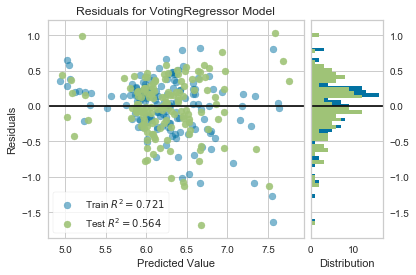

In [15]:
#### PLOT RESIDUALS ON EREG ####

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(ereg)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [16]:
final = all_fanta['fanta_18_19'].dropna()
final['Mf_predicted'] = list(ereg.predict(X_test))

In [17]:
final[final.R_2018=='P'][['Nome_2018', 'R_2018', 'Mf_2019']].sort_values(by='Mf_2019', ascending=False).iloc[:3].append(
final[final.R_2018=='D'][['Nome_2018', 'R_2018', 'Mf_2019']].sort_values(by='Mf_2019', ascending=False).iloc[:8].append(
final[final.R_2018=='C'][['Nome_2018', 'R_2018', 'Mf_2019']].sort_values(by='Mf_2019', ascending=False).iloc[:8].append(
final[final.R_2018=='A'][['Nome_2018', 'R_2018', 'Mf_2019']].sort_values(by='Mf_2019', ascending=False).iloc[:6])))

,Nome_2018,R_2018,Mf_2019
124,SIRIGU,P,5.53
40,DONNARUMMA G,P,5.47
24,HANDANOVIC,P,5.32
86,ANSALDI,D,6.77
130,KOLAROV,D,6.70
119,HATEBOER,D,6.57
121,GOSENS,D,6.54
32,CHIELLINI,D,6.46
139,N'KOULOU,D,6.31
63,ACERBI,D,6.31


In [18]:
final[final.R_2018=='P'][['Nome_2018', 'R_2018', 'Mf_predicted']].sort_values(by='Mf_predicted', ascending=False).iloc[:3].append(
final[final.R_2018=='D'][['Nome_2018', 'R_2018', 'Mf_predicted']].sort_values(by='Mf_predicted', ascending=False).iloc[:8].append(
final[final.R_2018=='C'][['Nome_2018', 'R_2018', 'Mf_predicted']].sort_values(by='Mf_predicted', ascending=False).iloc[:8].append(
final[final.R_2018=='A'][['Nome_2018', 'R_2018', 'Mf_predicted']].sort_values(by='Mf_predicted', ascending=False).iloc[:6])))

,Nome_2018,R_2018,Mf_predicted
24,HANDANOVIC,P,5.721016
40,DONNARUMMA G,P,5.274262
104,STRAKOSHA,P,5.247030
130,KOLAROV,D,6.522229
94,SKRINIAR,D,6.481375
36,DE VRIJ,D,6.467164
44,KOULIBALY,D,6.445712
77,ROMULO,D,6.330991
83,ALEX SANDRO,D,6.296240
58,DE SILVESTRI,D,6.260372


# Italian fantasy Football Machine Learning Part 2

In [70]:
fanta_datasets = {}
mf_next_year = []

flatten = lambda l: [item for sublist in l for item in sublist]

def roll_and_shift(final_dataset, cols):
    for col in cols:
        tmp, tmp2 = ([],[])
        for name, group in final_dataset.groupby('Nome'):
            tmp.append(group.sort_values(by=['Nome','Final_Year'])[col].shift(1).values)
            tmp2.append(group.sort_values(by=['Nome','Final_Year'])[col].shift(2).values)
        final_dataset[col+'_previous_year'] = flatten(tmp)
        final_dataset[col+'_previous_year_2'] = flatten(tmp2)
    return final_dataset
   
def is_greater(final_dataset, cols):
    for col in cols:
        try:
            final_dataset['Is_'+col+'_greater'] = final_dataset[col] >= final_dataset[col+'_previous_year']
            final_dataset['Is_'+col+'_greater_2'] = final_dataset[col+'_previous_year'] >= final_dataset[col+'_previous_year_2']
        except KeyError:
            continue
    return final_dataset

def means_per_team(final_dataset, cols):
    for col in cols:
        final_dataset[col + '_mean'] = final_dataset.groupby(['Squadra','Final_Year'])[col].transform('mean')
    return final_dataset

for i in [15,16,17,18,19]:
    try:
        fanta_datasets['fanta_20{}_20{}'.format(i,i+1)] = pd.read_excel(
                                                        'Statistiche_Fantacalcio_20{}-{}.xlsx'.format(i,i+1), sheet_name='Tutti')
        fanta_datasets['fanta_20{}_20{}'.format(i,i+1)]['Final_Year'] = 2001 + i
    except FileNotFoundError:
        pass

final_dataset = pd.DataFrame()

for k,v in fanta_datasets.items():
    final_dataset = final_dataset.append(v)

final_dataset = final_dataset.reset_index(drop=True)
final_dataset['Is_First_Season'] = final_dataset.groupby('Nome').cumcount() < 1
final_dataset = means_per_team(final_dataset, [l for l in final_dataset.columns if l not in
                                                  ['Id','R','Nome','Squadra','Mv','Final_Year',
                                                  'Is_First_Season']])

lbl_teams = {k:v+1 for v,k in enumerate(final_dataset.Squadra.unique())}
final_dataset['Squadra_T'] = final_dataset.Squadra.map(lbl_teams)

for name, group in final_dataset.groupby('Nome'):
    mf_next_year.append(group.sort_values(by=['Nome','Final_Year'])['Mf'].shift(-1).values)
final_dataset = final_dataset.sort_values(by=['Nome','Final_Year']).reset_index(drop=True)
final_dataset['Mf_next_year'] = flatten(mf_next_year)

final_dataset = roll_and_shift(final_dataset, [l for l in final_dataset.columns if l not in
                                                  ['Id','R','Nome','Squadra','Mv','Mf_next_year','Final_Year',
                                                  'Is_First_Season']])
final_dataset = is_greater(final_dataset, [l for l in final_dataset.columns if l not in
                                                  ['Id','R','Nome','Squadra','Mv','Mf_next_year','Final_Year',
                                                  'Is_First_Season']])
lbl_R = {'P':0, 'D':1, 'C':2, 'A':3}

final_dataset['R_T'] = final_dataset['R'].map(lbl_R)

In [71]:
#### CREATING DATASET #####

final_dataset = final_dataset[final_dataset.Final_Year != 2020]
final_dataset = final_dataset.fillna(0)
final_dataset_infer = final_dataset[final_dataset.Final_Year == 2019]
final_dataset = final_dataset[final_dataset.Mf_next_year != 0]
final_dataset_training = final_dataset[final_dataset.Final_Year != 2019]


In [61]:
fcol = [l for l in final_dataset.columns if l not in ['Id','R','Nome','Squadra','Final_Year','Mf_next_year']]

X_train, X_test, Y_train, Y_test = train_test_split(final_dataset[fcol].values, final_dataset['Mf_next_year'].values, 
                                                    test_size=0.08, random_state=42)

Lo score sul training è  0.4975356685729547
Lo score sul test è  0.49498243638525924


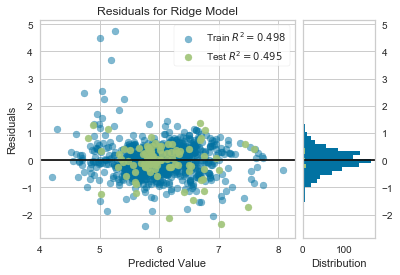

In [62]:
lc = Ridge(alpha=0.05,normalize=True)
lc.fit(X_train, Y_train)
print('Lo score sul training è ', lc.score(X_train, Y_train))
print('Lo score sul test è ', lc.score(X_test, Y_test))

#### PLOT RESIDUALS ON LC ####

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(lc)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Lo score sul training è  0.6650008737537767
Lo score sul test è  0.4963114546605728


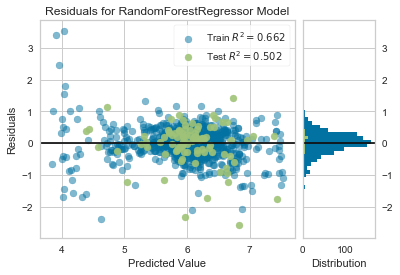

In [63]:
####### Let's try with random forest #######

rf = RandomForestRegressor(n_estimators=150, max_depth=50, min_samples_leaf=10, n_jobs=-1)
rf.fit(X_train, Y_train)
print('Lo score sul training è ', rf.score(X_train, Y_train))
print('Lo score sul test è ', rf.score(X_test, Y_test))

#### PLOT RESIDUALS ON RF ####

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Lo score sul training è  0.6106989876997909
Lo score sul test è  0.5136479686252846


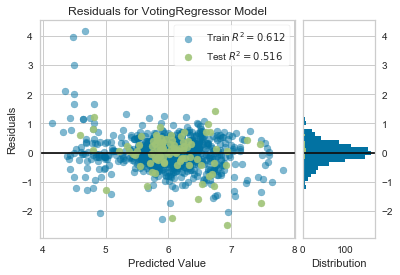

In [64]:
ereg = VotingRegressor([('lc', lc), ('rf', rf)])
ereg.fit(X_train, Y_train)
print('Lo score sul training è ', ereg.score(X_train, Y_train))
print('Lo score sul test è ', ereg.score(X_test, Y_test))

#### PLOT RESIDUALS ON EREG ####

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(ereg)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [77]:
#### Let's infere on 2018-2019 data ######

final_dataset_infer['Mf_predicted'] = np.round(ereg.predict(final_dataset_infer[fcol].values),2)
final_dataset_infer.to_csv('final.csv', sep=';')